# Preliminaries

In this notebook we explore some preliminary points before we begin actually exploring the implementation of the Galerkin finite element method in depth.

In particular we will discuss:

- A simple Helmholtz-type PDE in strong form.
- An analytical solution.
- The conversion from the strong form to the weak form, suitable for finite element analysis.
- The construction of a mesh on a simple domain.
- The construction of the lowest-order Lagrange finite element basis.
- The interpolation operator.
- A simple interpolation estimate.

> The notebook is not complete - your task will be to complete the missing
> parts and submit it as the first part of the coursework.

> The interactive elements of this notebook only work when the notebook is
> executed in a notebook environment.

## The Poisson problem

Find $u : \Omega := [0, 1] \to \mathbb{R}$ such that

$$
- \Delta u = f,
$$

with Dirichlet-type boundary conditions

$$
u(0) = 0, \quad u(1) = 0.
$$

### Exercise 1

Comment on the following aspects of this PDE:

1. Boundary value problem or initial value problem?
2. Linear or non-linear, and why?
3. For $k^2 > 0$, elliptic, parabolic or hyperbolic?
4. Neumann or Dirichlet problem?
5. Homogeneous or non-homogeneous boundary conditions?


### Solution (Exercise 1)

1. **Its a Boundary value problem** 
--> The values of the solution *u* are given at the spatial boundaries (x = 0) and (x = 1), rather than at an initial time.

2. **Its a PDE is linear.** --> The differential operator (-Δu) is linear with respect to *u*, and the equation excludes nonlinear functions or products involving *u* and its derivatives.

3. **The Poisson equation is elliptic here.** --> Elliptic PDEs are generally linked to equilibrium processes, with the Laplacian (Δ) serving as the primary marker of ellipticity.

4. **Its a Dirichlet Problem** --> The function *u* has its values defined on the boundary, specifically u(0) = 0 and u(1) = 0.

5. **The boundary conditions are homogeneous** --> As *u* equals zero at both boundaries.


### Exercise 2

Once we have finished, we would like to *verify* that our finite element code
can correctly solve a PDE. One straightforward way to do this is via the
method of manufactured solutions. We will invent a solution
$u_{\mathrm{exact}}$ that satisfies the Dirichlet boundary conditions, then
derive $f$ via substitution into the strong form of the PDE. On a sequence of
finer and finer meshes, we will solve our PDE using our finite element code
and check that our numerical solution converges to $u_{\mathrm{exact}}$ at
the *correct* rate. If it does, then it is likely we have a correct
implementation.

Let $u_{\mathrm{exact}} = \sin(cx)$ with $c$ an unknown positive constant.
Find the values for $c$ such that the Dirichlet boundary conditions are
satisfied.


--> Solution:

To satisfy the Dirichlet boundary conditions (u(0) = 0) and (u(1) = 0), we are given:

u_exact = sin(c * x)

We must find values of (c > 0) such that:

- sin(c * 0) = 0 — always satisfied,
- sin(c * 1) = 0 ⇒ sin(c) = 0

So, c = n * pi, where n ∈ ℕ. The smallest positive value is : c = pi


Find $f$ such that the strong form of the PDE is satisfied with
$u_{\mathrm{exact}} = \sin(cx)$.

We are addressing the Poisson equation:

- d²u/dx² = f

Given the exact solution:

u_exact = sin(πx)

To determine f, we calculate the second derivative:

d²/dx² [sin(πx)] = -π² sin(πx)

Thus, the source term is:

f(x) = π² sin(πx)

### Exercise 3

Adjust the code below to plot the solution $u_{\mathrm{exact}}$ for a fixed
value of $c$ such that the boundary conditions are satisfied. Extend the code
to also plot the $f$ you derived previously. Add axis labels and enable a
legend for the graph.

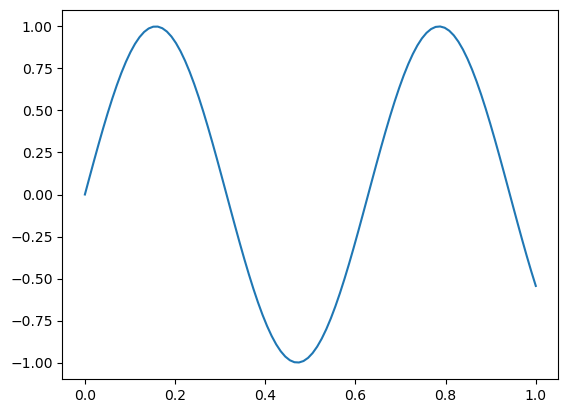

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

c = 10.0

x = np.linspace(0.0, 1.0, num=100)
u_exact = np.sin(c * x)

plt.plot(x, u_exact)

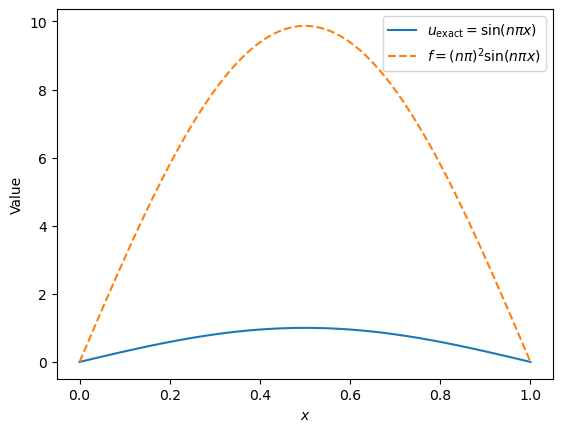

In [25]:
# Import necessary libraries for solving the Poisson equation
import numpy as np
import matplotlib.pyplot as plt

n = 1  # Choose n=1,2,3,...
c = n * np.pi  # u(0)=u(1)=0

x = np.linspace(0.0, 1.0, num=100)
u_exact = np.sin(c * x)
f = c**2 * np.sin(c * x)  # -u'' = f

plt.plot(x, u_exact, label=r"$u_{\mathrm{exact}} = \sin(n\pi x)$")
plt.plot(x, f, "--", label=r"$f = (n\pi)^2 \sin(n\pi x)$")

plt.xlabel("$x$")
plt.ylabel("Value")
plt.legend()
plt.savefig('plot.png')
plt.show()

### Exercise 4

Derive the weak formulation of the partial differential equation. You will
need the following integration by parts result.

For functions $u, v \in H^1(\Omega)$ the following integration by parts
result holds

$$
\int_{0}^{1} -u'' v \; \mathrm{d}x = [-u' v]_0^1 + \int_0^1 u' v' \; \mathrm{d}x.
$$

### Exercise 4 Solution --->

We are provided with the strong form of the Poisson equation:

$$
- u''(x) = f(x), \quad x \in [0, 1], \quad u(0) = u(1) = 0
$$

We multiply both sides by a test function $v(x) \in H_0^1([0, 1])$ and integrate over the interval:

$$
\int_0^1 -u''(x) v(x) \, dx = \int_0^1 f(x) v(x) \, dx
$$

Applying the integration by parts formula:

$$
\int_0^1 -u'' v \, dx = [-u' v]_0^1 + \int_0^1 u' v' \, dx
$$

Since $v(0) = v(1) = 0$ (as $v \in H_0^1$), the boundary term evaluates to zero:

$$
[-u' v]_0^1 = 0
$$

Thus, the weak form is:

$$
\int_0^1 u'(x) v'(x) \, dx = \int_0^1 f(x) v(x) \, dx
$$

## Building finite element basis functions

### The mesh

The mesh is a discretisation of the domain $\Omega$ into cells.

A uniform mesh $\mathcal{T}_h$ of $\Omega$ is a partitioning of the mesh
constructed from $N$ disjoint cells $K_i$

$$
\mathcal{T}_h = \{ K_i = (x_i, x_{i+1}) \; | \; i = 0, 1, \dots, N-1 \},
$$

with $N + 1$ vertices

$$
0 = x_0 < x_1 < \cdots < x_N = 1,
$$

and fixed mesh size $h = x_{i+1} - x_i = 1/(N - 1)$. Note that

$$
\bigcup K_i = \Omega.
$$

### The lowest-order Lagrange finite element space

The $P_1$ finite element space is defined as

$$
V_h = \{ v_h \in C^0(\Omega) : v_h|_{K_i} \text{ is linear for all } K_i \in \mathcal{T}_h \}.
$$

Each function $v_h \in V_h$ is $C^0$ continuous and piecewise linear on the mesh.

### Explicit piecewise definition of the basis functions

On $ K_i = (x_i, x_{i+1})$ the global piecewise definition

$$
\varphi_i(x) =
\begin{cases}
\dfrac{x_{i+1} - x}{x_{i+1} - x_i}, & x \in [x_i, x_{i+1}], \\[10pt]
0, & \text{otherwise,}
\end{cases}
$$

and

$$
\varphi_{i+1}(x) = \begin{cases}
\dfrac{x - x_i}{x_{i+1} - x_i}, & x \in [x_i, x_{i+1}], \\[10pt]
0, & \text{otherwise.}
\end{cases}
$$

Each $\varphi_j$ is linear on the two elements adjacent to $x_j$ and zero elsewhere.

### Nodal basis property

The standard hat functions $\{ \varphi_j \}_{j=0}^N$ form a basis for $V_h$.
Each basis function $\varphi_j$ has the property

$$
\varphi_j(x_i) = \delta_{ij} = \begin{cases}
1 & \text{if } i = j, \\[6pt]
0 & \text{otherwise.}
\end{cases}
$$

### Visualisation

In the next cell we show a plot of the finite element basis functions on an adjustable mesh.

Begin by dragging the slider to $N = 2$. The endpoints of the single cell
$K_0$ are shown by the grey vertical lines at $x = 0$ and $x = 1$. The
coloured circles along the lower axis denote the location of the two *degrees
of freedom* $x_j$ associated with the basis functions $\varphi_j$. The two
linear basis functions, along with each associated degree of freedom, are
plotted in the same colour.

> The $N = 2$ case is similar to the situation when we construct the local
finite element basis functions later on in the course, and then pull back the
integral from each global cell $K_j = (x_j, x_{j + 1})$ to the local cell
$\hat{K} = (0, 1)$.

Experiment with increasing $N$. Match up what you see in the plot with the
equations and properties discussed in the previous paragraphs.

In [26]:
# Generate a uniform mesh on [0, 1] with N nodes
def generate_mesh(N):
    """Generate a uniform mesh on [0, 1] with N nodes."""
    return np.linspace(0.0, 1.0, N)

# Generate P1 basis functions for a uniform mesh
def p1_basis_function(x, nodes, j):
    """Evaluate the j-th P1 basis function at points x."""
    phi = np.zeros_like(x)
    if j > 0:
        left = (x >= nodes[j - 1]) & (x <= nodes[j])
        phi[left] = (x[left] - nodes[j - 1]) / (nodes[j] - nodes[j - 1])
    if j < len(nodes) - 1:
        right = (x >= nodes[j]) & (x <= nodes[j + 1])
        phi[right] = (nodes[j + 1] - x[right]) / (nodes[j + 1] - nodes[j])
    return phi

# Interactive plotting of P1 basis functions
def plot_p1_basis(N=2):
    """Plot all P1 basis functions on a mesh with N nodes."""
    resolution = 500
    nodes = generate_mesh(N)
    x = np.linspace(0, 1, resolution)

    plt.figure()
    for j in range(N):
        phi = p1_basis_function(x, nodes, j)
        (line,) = plt.plot(x, phi, label=f"$\\varphi_{j}(x)$")
        plt.scatter(nodes[j], 0.0, color=line.get_color())

    # Plot vertical lines at element boundaries and label elements
    for i in range(N - 1):
        plt.axvline(nodes[i], color="gray", linestyle="-", alpha=0.6)
        plt.axvline(nodes[i + 1], color="gray", linestyle="-", alpha=0.6)
        # Place label in the middle of the element
        mid_point = (nodes[i] + nodes[i + 1]) / 2
        plt.text(mid_point, -0.1, f"$K_{{{i}}}$", ha="center", va="center", fontsize=10)

# Set plot limits and labels
    plt.xlabel(r"$x$", fontsize=12)
    plt.ylabel(r"$\varphi_j(x)$", fontsize=12)
    plt.xticks(nodes)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="upper right", fontsize=9)
    plt.show()

In [27]:
interact(plot_p1_basis, N=(2, 10))

interactive(children=(IntSlider(value=2, description='N', max=10, min=2), Output()), _dom_classes=('widget-int…

<function __main__.plot_p1_basis(N=2)>

### The interpolation operator $I_h$

The $P_1$ interpolation operator $I_h: C^0(\Omega) \to V_h$ is defined as:

$$
(I_h u)(x) = \sum_{j=0}^N u(x_j) \varphi_j(x),
$$

where $u(x_j)$ are the nodal values of $u$.

> The nodal values of the $P^1$ space are associated with the vertices of the
> mesh. In this course we do not pay any particular care to the association
> between the topological entities of the mesh (e.g. vertices) and the nodes
> (or degrees of freedom) of the finite element space $V_h$. We also do not
> strictly separate the topology of the mesh from its geometry. These
> precisions will be made in the Numerical Methods for Variational Problems
> course in Semester 3.

The interpolation operator has the following properties:

1. Exact (to machine precision) reproduction of linear functions, i.e. if $u$
is linear, then $I_h u = u$ everywhere.
2. $I_h u$ is $C^0$ on $\Omega$.
3. The basis is local in a spatial sense - the value of $(I_h u)(x)$ depends
   only on $u(x_j)$ at the nearest nodes.
4. The construction of $\varphi_j$ ensures that the interpolant $I_h u$
   matches $u$ at the vertices, i.e. $(I_h u)(x_j) = u(x_j)$.

The interpolant of $u$ can be written in terms of the two local basis
functions

$$
I_h u(x) = u(x_i)\varphi_i(x) + u(x_{i+1})\varphi_{i+1}(x),
$$

and substituting the previous definition of the basis

$$
I_h u(x) = u(x_i) \frac{x_{i+1} - x}{x_{i+1} - x_i} \;+\; u(x_{i+1}) \frac{x - x_i}{x_{i+1} - x_i}, \quad x \in [x_i, x_{i+1}].
$$

### Exercise 5

The interpolation error estimate states that the error between the exact
solution $u_{\mathrm{exact}} := u \in H^2$ and its interpolant $I_h u \in
V_h$ is given by

$$
\lVert u - I_h u \rVert_{H^1} \leq C h | u |_{H^2}
$$

where $\lVert \cdot \rVert_{H^1}^2$ is the standard $ H^1 $ norm

$$
\lVert v \rVert_{H^1} = \lVert v \rVert_{L^2}^2 + \lVert \nabla v \rVert_{L^2}^2,
$$

and $ | \cdot |_{H^2} $ is the $H^2$-seminorm

$$
    | u |_{H^2} = \left( \int_0^1 | u''(x) |^2 dx \right)^{1/2}.
$$

For the exact solution given above, derive an explicit bound for the
interpolation error in terms of the parameters $C$, $h$, and $c$. In words,
comment on the dependence between the parameters and the error, and give an
intepretation of the result.

> The extended version of the previous result, called a finite element error
> bound, will be covered in the theoretical part of the course. The finite
> element error bound states that the error between the exact solution and the
> linear Lagrange finite element solution $u_h$ is given by
>
> $$
  \lVert u - u_h \rVert_{H^1} \leq C h | u |_{H^2}
  $$
>
> which is of a very similar form to the interpolation error estimate we just
> saw. Note that $C$ is a different positive constant to the one you have just
> seen - this applies throughout the course!

### Exercise 5 Solution --->

We are provided with the interpolation error estimate:

$$
\| u - I_h u \|_{H^1} \leq C h | u |_{H^2}
$$

For the exact solution:

$$
u(x) = \sin(cx)
$$

we calculate its second derivative:

$$
u''(x) = -c^2 \sin(cx)
$$

The $H^2$ seminorm is then:

$$
| u |_{H^2} = \left( \int_0^1 | u''(x) |^2 dx \right)^{1/2}
= \left( \int_0^1 c^4 \sin^2(cx) \, dx \right)^{1/2}
= c^2 \left( \int_0^1 \sin^2(cx) \, dx \right)^{1/2}
$$

Given the identity $\int_0^1 \sin^2(cx) dx = \frac{1}{2}$ when $c = n\pi$:

$$
| u |_{H^2} = c^2 \cdot \sqrt{\frac{1}{2}} = \frac{c^2}{\sqrt{2}}
$$

Substituting into the interpolation error estimate:

$$
\| u - I_h u \|_{H^1} \leq C h \cdot \frac{c^2}{\sqrt{2}} = \frac{C c^2 h}{\sqrt{2}}
$$

### Exercise 6

Having seen the interpolation error estimate is is helpful to play around
with the parameters $c$, controlling how oscillatory our solution $u$ is, and
$h = 1/N$ and simply observe how the interpolant $I_h u$ changes.

Matplotlib already implements the linear interpolant; you give it an array of
values $(I_h u)(x_j)$ of the function $u$ at the nodes $x_j$ and it will plot
the linear interpolant $I_h u$.

In the box below the plot explain your observations and relate them back to
the interpolation error estimate we just saw.

In [28]:
def u_exact(N: int = 2, c: int = 1, plot_fine=False):
    nodes = np.linspace(0.0, 1.0, num=N)
    # This next statement is precisely the nodal values of the interpolant of u
    Iu = np.sin(c * np.pi * nodes)

    for node in nodes:
        plt.axvline(node, color="gray", linestyle="-", alpha=0.6)

    (line,) = plt.plot(nodes, Iu, "-", label="$I_h u$")
    plt.plot(nodes, Iu, "o", color=line.get_color(), label="$(I_h u)(x_j)$")
    if plot_fine:
        xs = np.linspace(0.0, 1.0, num=500)
        y = np.sin(c * np.pi * xs)
        plt.plot(xs, y, "-", label="$u$")

    plt.ylim(-1.1, 1.1)
    plt.xlim(-0.1, 1.1)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$u$")

    plt.legend(loc="lower left")


interact(u_exact, N=(2, 100), c=(1, 20), plot_fine=False)

interactive(children=(IntSlider(value=2, description='N', min=2), IntSlider(value=1, description='c', max=20, …

<function __main__.u_exact(N: int = 2, c: int = 1, plot_fine=False)>

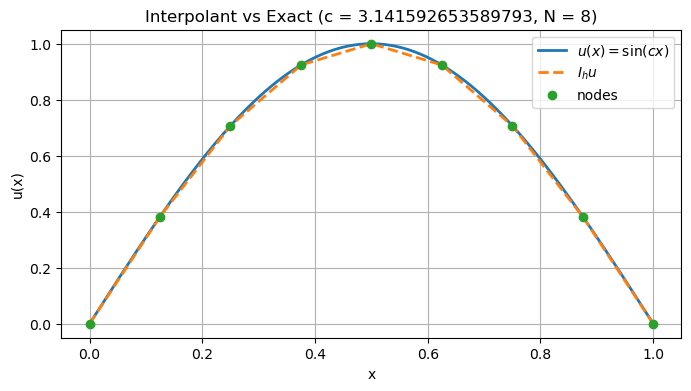

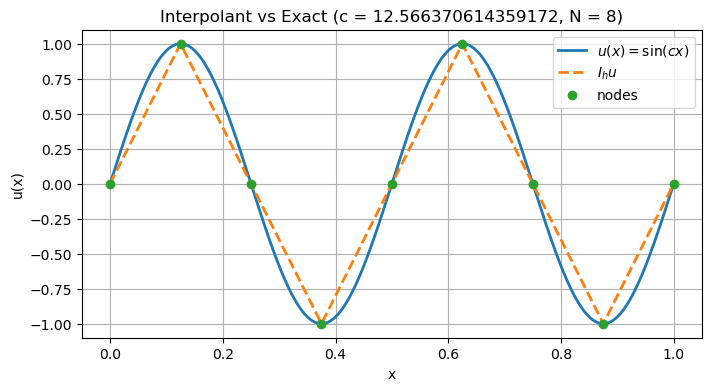

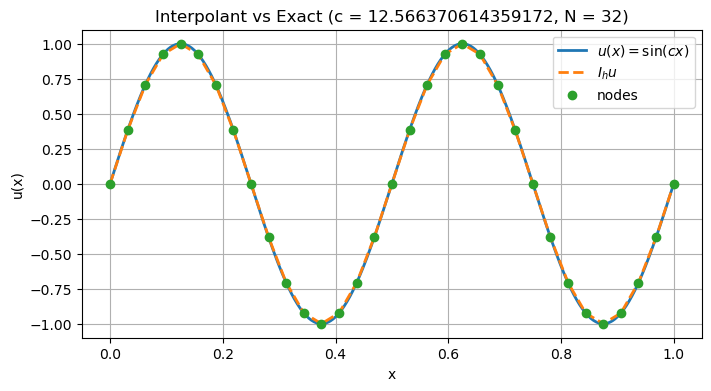

In [29]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Plot the linear interpolant of u = sin(cx) on a uniform mesh
def plot_interpolant(c: float, N: int):

    """
    Plot exact function u = sin(cx) and its linear interpolant I_h u
    using N subintervals on [0, 1].
    """
    # Generate a uniform mesh with N subintervals
    # Mesh and nodal values
    x_nodes = np.linspace(0, 1, N + 1)
    u_nodes = np.sin(c * x_nodes)  # values at nodes

    # Fine grid for plotting
    x_fine = np.linspace(0, 1, 1000)
    u_exact = np.sin(c * x_fine)
    u_interp = np.interp(x_fine, x_nodes, u_nodes)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_fine, u_exact, label=r'$u(x) = \sin(cx)$', linewidth=2)
    plt.plot(x_fine, u_interp, '--', label=r'$I_h u$', linewidth=2)
    plt.plot(x_nodes, u_nodes, 'o', label='nodes')
    plt.title(f'Interpolant vs Exact (c = {c}, N = {N})')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Try different values of c and N
plot_interpolant(c=np.pi, N=8)
plot_interpolant(c=4 * np.pi, N=8)
plot_interpolant(c=4 * np.pi, N=32)


### Exercise 6 Solution ---> 

We observe the behaviour of the linear interpolant $I_h u$ for different values of $c$ and mesh size $h = 1/N$.

#### Case 1: $c = \pi$, $N = 8$

- The solution is smooth and low frequency.
- Even with a coarse mesh, the interpolant $I_h u$ closely matches $u(x)$.
- The interpolation error is small.

#### Case 2: $c = 4\pi$, $N = 8$

- The solution oscillates rapidly.
- The interpolant fails to capture the shape accurately — significant error is visible.
- This confirms the $c^2$ dependence in the error estimate.

#### Case 3: $c = 4\pi$, $N = 32$

- A finer mesh greatly improves the accuracy.
- The interpolant now follows the true solution much more closely.
- This illustrates how reducing $h$ compensates for higher $c$.


